<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/CNNs/Deep%20Architectures/LeNet%20With%20Cuda/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

## Data loading

In [2]:
batch_size = 128

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([128, 3, 32, 32])
torch.Size([3, 32, 32])
7


## Visualise data

In [7]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [8]:
npimg = img.numpy()
print(npimg.shape)

(3, 32, 32)


In [9]:
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

(32, 32, 3)


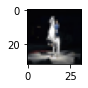

In [10]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## LeNet

In [12]:
import torch.nn as nn

In [13]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        print(x.shape)
        x = self.cnn_model(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc_model(x)
        print(x.shape)
        return x

In [14]:
net = LeNet()
out = net(images)

torch.Size([128, 3, 32, 32])
torch.Size([128, 16, 5, 5])
torch.Size([128, 400])
torch.Size([128, 10])


In [15]:
print(out.shape)

torch.Size([128, 10])


In [16]:
max_values, pred_class = torch.max(out.data, 1)
print(pred_class.shape)

torch.Size([128])


## Training LeNet

In [17]:
import torch.optim as optim

In [18]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

Tesla T4
1


In [19]:
gpu = torch.device('cuda:0')

In [20]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x
    
    def evaluation(self, dataloader):
        total, correct = 0, 0
        for data in dataloader:
          inputs, labels = data
          inputs, labels = inputs.to(gpu), labels.to(gpu)
          outputs = self.forward(inputs)
          _, pred = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()
        return 100 * correct / total
    
    def fit(self, epochs,trainloader,testloader,loss_fn,opt):
          max_epochs =  epochs
          loss_arr = []
          loss_epoch_arr = []
          for epoch in range(epochs):
              for i, data in enumerate(trainloader, 0):
                  
                  inputs, labels = data
                  inputs, labels = inputs.to(gpu), labels.to(gpu)
                  
                  opt.zero_grad()
                  
                  outputs = self.forward(inputs)
                  loss = loss_fn(outputs, labels)
                  loss.backward()
                  opt.step()
                  
                  loss_arr.append(loss.item())
              
              loss_epoch_arr.append(loss.item())
              train_acc = self.evaluation(trainloader)
              test_acc = self.evaluation(testloader)
              print('Epoch: %d/%d, Train acc: %0.2f, Test acc: %0.2f' % (epoch+1, max_epochs, train_acc,test_acc ) )
          plt.plot(loss_epoch_arr)
          plt.show() 

Epoch: 1/16, Train acc: 38.34, Test acc: 38.03
Epoch: 2/16, Train acc: 42.46, Test acc: 42.65
Epoch: 3/16, Train acc: 45.56, Test acc: 45.53
Epoch: 4/16, Train acc: 49.66, Test acc: 48.85
Epoch: 5/16, Train acc: 51.96, Test acc: 50.49
Epoch: 6/16, Train acc: 52.62, Test acc: 50.51
Epoch: 7/16, Train acc: 55.74, Test acc: 52.19
Epoch: 8/16, Train acc: 57.23, Test acc: 53.32
Epoch: 9/16, Train acc: 57.73, Test acc: 53.14
Epoch: 10/16, Train acc: 59.59, Test acc: 53.95
Epoch: 11/16, Train acc: 60.18, Test acc: 54.19
Epoch: 12/16, Train acc: 61.14, Test acc: 54.55
Epoch: 13/16, Train acc: 62.16, Test acc: 54.94
Epoch: 14/16, Train acc: 63.38, Test acc: 55.02
Epoch: 15/16, Train acc: 63.32, Test acc: 54.68
Epoch: 16/16, Train acc: 64.01, Test acc: 54.52


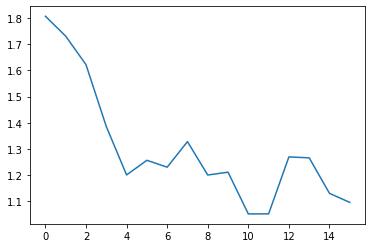

CPU times: user 3min 22s, sys: 2.34 s, total: 3min 24s
Wall time: 3min 30s


In [21]:
%%time
epochs = 16
net = LeNet()
net = net.to(gpu)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())
net.fit(epochs,trainloader,testloader,loss_fn,opt)